Author: Seth V. Neel (sethneel@wharton.upenn.edu)
### `aif360.gerryfair`
This notebook demonstrates the main features of the `gerryfair` package, contributed to the [aif360](https://aif360.mybluemix.net) project from IBM. The first iteration of this code was initially developed for the papers [Preventing Fairness Gerrymandering: Auditing and Learning for Subgroup Fairness](https://arxiv.org/abs/1711.05144) and [An Empirical Study of Rich Subgroup Fairness for Machine Learning](https://arxiv.org/abs/1808.08166). Rich subgroup fairness is a variant of statistical fairness that seeks to equalize statistical rates (false positive, false negative rate, statistical parity) across exponentially large collections of protected subgroups, rather than a handful of subgroups defined by a few sensitive attributes. For further background on rich subgroup fairness, see [this](https://www.youtube.com/watch?v=PZ-UyOTtwng) talk by Michael Kearns for TCS+, and [this](http://www.birs.ca/events/2018/5-day-workshops/18w5189/videos/watch/201805040949-Neel.html) talk from Seth Neel at the Banff Centre. 
 
### contributors
This code has been the product of many researchers, it is released as a stand alone package with its own API [here](https://github.com/algowatchpenn/GerryFair). We thank **Michael Kearns** (@mkearns.cis.upenn.edu), **Aaron Roth** (aaroth@cis.upenn.edu), and **Steven Wu** (zsw@umn.edu) for their feedback on early experimental results. 

**Developers**: 
* **Seth Neel** (sethneel@wharton.upenn.edu)
* **William Brown** (wi.brown@columbia.edu)
* **Adel Boyarsky**
* **Aaron Hallac**
* **Arnab Sarker**

For bugs and support please contact Seth Neel.

In this notebook we: 
* `fit` a rich subgroup fair model, and use it to `predict` labels on the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult).
* Show how to use the `Auditor` class to audit black-box classifiers with respect to rich subgroup fairness
* Use brute-force auditing of a classifier to construct a 3d heatmap of rich subgroup unfairness using the functions `heatmap.py` 
* Trace out error-fairness Pareto curves across several choices of learning oracles: linear regression, regression trees, and kernelized ridge regression. 
* Explore the tradeoff between subgroup unfairness with respect to false positive rate vs. false negative rate when we only optimize for false positive rate, showing an inherent tradeoff in the two measures. 

First we import the necessary packages:

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.path.append("../")
from aif360.algorithms.inprocessing.gerryfair_classifier import *
from aif360.algorithms.inprocessing.gerryfair.clean import *
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import *
from aif360.algorithms.inprocessing.gerryfair.auditor import *
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
from IPython.display import IFrame
matplotlib.use('Agg')

### basics: `Model()`, `fit()`, `predict(), audit()`
We first demonstrate how to instantiate a `Model`, `fit` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=5000` which is in-line with time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is `gamma = .008`, our statistical rate is false positive rate or `FP`, and our weighted regression oracle is linear regression. We observe that the unconstrained (with no fairness constraint) classifier has error $.24$ and $\gamma$-disparity $.0225$. After $$ iterations we obtain a classifier that is approximately $\gamma$-fair, and has error $.35$. We note that we converge to a fair, and almost as accurate classifier after just a hundred iterations.


In [3]:
C = 100
print_flag = True
gamma = .005
max_iterations = 2000

fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP',
             max_iters=max_iterations, heatmapflag=False, heatmap_iter=max_iterations, heatmap_path='heatmap')
# balance flag artificially ensures mean(y) = .5
data_set = load_preproc_data_adult(sub_samp=200, balance=True)

# fit method
communities_all_errors, communities_violations = fair_model.fit(data_set,
                                                 early_termination=True, return_values=True)
# predict method
dataset_yhat = fair_model.predict(data_set)



iteration: 1, error: 0.24, fairness violation: 0.021700000000000004, violated group size: 0.21
iteration: 2, error: 0.345, fairness violation: 0.010850000000000002, violated group size: 0.21
iteration: 3, error: 0.38000000000000006, fairness violation: 0.007233333333333335, violated group size: 0.21
iteration: 4, error: 0.3975, fairness violation: 0.005425000000000001, violated group size: 0.21
iteration: 5, error: 0.40800000000000003, fairness violation: 0.00434, violated group size: 0.21
iteration: 6, error: 0.415, fairness violation: 0.0036166666666666686, violated group size: 0.21
iteration: 7, error: 0.42, fairness violation: 0.003100000000000001, violated group size: 0.21
iteration: 8, error: 0.42375, fairness violation: 0.002712500000000002, violated group size: 0.29
iteration: 9, error: 0.4266666666666667, fairness violation: 0.0024111111111111117, violated group size: 0.21
iteration: 10, error: 0.4270000000000001, fairness violation: 0.0021700000000000005, violated group size:

iteration: 78, error: 0.38141025641025644, fairness violation: 0.002093589743589744, violated group size: 0.27
iteration: 79, error: 0.3805696202531646, fairness violation: 0.0021354430379746845, violated group size: 0.27
iteration: 80, error: 0.37975000000000003, fairness violation: 0.0021762500000000007, violated group size: 0.23
iteration: 81, error: 0.3785802469135803, fairness violation: 0.0023493827160493835, violated group size: 0.23
iteration: 82, error: 0.37743902439024396, fairness violation: 0.0025182926829268298, violated group size: 0.27
iteration: 83, error: 0.3763253012048192, fairness violation: 0.0026831325301204818, violated group size: 0.27
iteration: 84, error: 0.3752380952380952, fairness violation: 0.0028440476190476197, violated group size: 0.27
iteration: 85, error: 0.3741764705882353, fairness violation: 0.0030011764705882354, violated group size: 0.27
iteration: 86, error: 0.3730813953488372, fairness violation: 0.003186046511627908, violated group size: 0.27


iteration: 152, error: 0.35529605263157893, fairness violation: 0.004173684210526316, violated group size: 0.27
iteration: 153, error: 0.3552287581699346, fairness violation: 0.004164052287581701, violated group size: 0.27
iteration: 154, error: 0.3551623376623376, fairness violation: 0.004154545454545457, violated group size: 0.27
iteration: 155, error: 0.35509677419354846, fairness violation: 0.0041451612903225825, violated group size: 0.27
iteration: 156, error: 0.3550320512820513, fairness violation: 0.004135897435897438, violated group size: 0.27
iteration: 157, error: 0.35496815286624206, fairness violation: 0.004126751592356689, violated group size: 0.27
iteration: 158, error: 0.3549050632911392, fairness violation: 0.004117721518987343, violated group size: 0.27
iteration: 159, error: 0.35484276729559755, fairness violation: 0.0041088050314465425, violated group size: 0.27
iteration: 160, error: 0.35478125, fairness violation: 0.004100000000000001, violated group size: 0.27
ite

iteration: 227, error: 0.3421806167400882, fairness violation: 0.004983259911894273, violated group size: 0.23
iteration: 228, error: 0.3421929824561403, fairness violation: 0.004973245614035088, violated group size: 0.27
iteration: 229, error: 0.34220524017467246, fairness violation: 0.004963318777292577, violated group size: 0.27
iteration: 230, error: 0.34221739130434786, fairness violation: 0.004953478260869565, violated group size: 0.27
iteration: 231, error: 0.3422294372294373, fairness violation: 0.004943722943722945, violated group size: 0.23
iteration: 232, error: 0.3422413793103448, fairness violation: 0.004934051724137933, violated group size: 0.23
iteration: 233, error: 0.3422532188841202, fairness violation: 0.004924463519313307, violated group size: 0.23
iteration: 234, error: 0.34226495726495726, fairness violation: 0.0049149572649572655, violated group size: 0.27
iteration: 235, error: 0.34227659574468083, fairness violation: 0.004905531914893617, violated group size: 0

iteration: 301, error: 0.3390863787375416, fairness violation: 0.0047538205980066466, violated group size: 0.23
iteration: 302, error: 0.33900662251655633, fairness violation: 0.004755960264900664, violated group size: 0.27
iteration: 303, error: 0.33892739273927397, fairness violation: 0.004758085808580859, violated group size: 0.27
iteration: 304, error: 0.3388486842105263, fairness violation: 0.004760197368421054, violated group size: 0.27
iteration: 305, error: 0.33877049180327873, fairness violation: 0.004762295081967217, violated group size: 0.23
iteration: 306, error: 0.33869281045751637, fairness violation: 0.004764379084967322, violated group size: 0.27
iteration: 307, error: 0.33861563517915316, fairness violation: 0.0047664495114006535, violated group size: 0.27
iteration: 308, error: 0.33853896103896114, fairness violation: 0.004768506493506495, violated group size: 0.27
iteration: 309, error: 0.338462783171521, fairness violation: 0.0047705501618123, violated group size: 0

iteration: 375, error: 0.3360133333333334, fairness violation: 0.004859733333333336, violated group size: 0.27
iteration: 376, error: 0.3360372340425532, fairness violation: 0.0048539893617021304, violated group size: 0.23
iteration: 377, error: 0.3360610079575597, fairness violation: 0.004848275862068969, violated group size: 0.27
iteration: 378, error: 0.3360846560846561, fairness violation: 0.004842592592592596, violated group size: 0.27
iteration: 379, error: 0.33610817941952503, fairness violation: 0.004836939313984171, violated group size: 0.27
iteration: 380, error: 0.33613157894736845, fairness violation: 0.004831315789473688, violated group size: 0.27
iteration: 381, error: 0.3361548556430446, fairness violation: 0.004825721784776906, violated group size: 0.23
iteration: 382, error: 0.33617801047120416, fairness violation: 0.0048201570680628325, violated group size: 0.23
iteration: 383, error: 0.336201044386423, fairness violation: 0.004814621409921674, violated group size: 0.

iteration: 449, error: 0.3370601336302896, fairness violation: 0.004533853006681518, violated group size: 0.27
iteration: 450, error: 0.33701111111111104, fairness violation: 0.004535777777777782, violated group size: 0.27
iteration: 451, error: 0.33696230598669624, fairness violation: 0.004537694013303773, violated group size: 0.27
iteration: 452, error: 0.3369137168141593, fairness violation: 0.0045396017699115086, violated group size: 0.27
iteration: 453, error: 0.3368653421633554, fairness violation: 0.004541501103752764, violated group size: 0.27
iteration: 454, error: 0.33681718061674004, fairness violation: 0.004543392070484586, violated group size: 0.27
iteration: 455, error: 0.33676923076923077, fairness violation: 0.004545274725274729, violated group size: 0.27
iteration: 456, error: 0.33672149122807016, fairness violation: 0.004547149122807022, violated group size: 0.27
iteration: 457, error: 0.33667396061269145, fairness violation: 0.004549015317286657, violated group size:

iteration: 524, error: 0.3339026717557252, fairness violation: 0.0046578244274809175, violated group size: 0.27
iteration: 525, error: 0.3338666666666667, fairness violation: 0.0046592380952380965, violated group size: 0.27
iteration: 526, error: 0.3338307984790875, fairness violation: 0.004660646387832701, violated group size: 0.27
iteration: 527, error: 0.33379506641366224, fairness violation: 0.004662049335863379, violated group size: 0.27
iteration: 528, error: 0.3337594696969697, fairness violation: 0.004663446969696971, violated group size: 0.27
iteration: 529, error: 0.3337240075614367, fairness violation: 0.004664839319470701, violated group size: 0.27
iteration: 530, error: 0.3336886792452831, fairness violation: 0.0046662264150943425, violated group size: 0.23
iteration: 531, error: 0.3336534839924671, fairness violation: 0.004667608286252355, violated group size: 0.27
iteration: 532, error: 0.33361842105263156, fairness violation: 0.004668984962406017, violated group size: 0

iteration: 598, error: 0.3311622073578595, fairness violation: 0.004988963210702341, violated group size: 0.27
iteration: 599, error: 0.3311853088480802, fairness violation: 0.004985141903171954, violated group size: 0.27
iteration: 600, error: 0.3312083333333333, fairness violation: 0.004981333333333333, violated group size: 0.27
iteration: 601, error: 0.3312312811980033, fairness violation: 0.004977537437603993, violated group size: 0.27
iteration: 602, error: 0.3312541528239203, fairness violation: 0.00497375415282392, violated group size: 0.23
iteration: 603, error: 0.3312769485903814, fairness violation: 0.004969983416252072, violated group size: 0.27
iteration: 604, error: 0.3312996688741723, fairness violation: 0.0049662251655629135, violated group size: 0.23
iteration: 605, error: 0.3313223140495868, fairness violation: 0.004962479338842975, violated group size: 0.23
iteration: 606, error: 0.3313448844884489, fairness violation: 0.004958745874587459, violated group size: 0.23
i

iteration: 672, error: 0.33267857142857143, fairness violation: 0.004736904761904763, violated group size: 0.27
iteration: 673, error: 0.33268945022288265, fairness violation: 0.004733878157503716, violated group size: 0.23
iteration: 674, error: 0.33270029673590507, fairness violation: 0.004730860534124629, violated group size: 0.27
iteration: 675, error: 0.3327111111111111, fairness violation: 0.004727851851851853, violated group size: 0.27
iteration: 676, error: 0.3327218934911243, fairness violation: 0.004724852071005918, violated group size: 0.27
iteration: 677, error: 0.3327326440177253, fairness violation: 0.0047218611521418034, violated group size: 0.27
iteration: 678, error: 0.33274336283185846, fairness violation: 0.004718879056047199, violated group size: 0.27
iteration: 679, error: 0.33275405007363773, fairness violation: 0.004715905743740797, violated group size: 0.23
iteration: 680, error: 0.3327647058823529, fairness violation: 0.004712941176470589, violated group size: 

iteration: 746, error: 0.33136058981233246, fairness violation: 0.004755630026809654, violated group size: 0.23
iteration: 747, error: 0.33133868808567607, fairness violation: 0.0047564926372155305, violated group size: 0.27
iteration: 748, error: 0.3313168449197862, fairness violation: 0.004757352941176471, violated group size: 0.27
iteration: 749, error: 0.33129506008010684, fairness violation: 0.004758210947930575, violated group size: 0.27
iteration: 750, error: 0.3312733333333333, fairness violation: 0.004759066666666667, violated group size: 0.27
iteration: 751, error: 0.33125166444740345, fairness violation: 0.0047599201065246345, violated group size: 0.27
iteration: 752, error: 0.33123005319148946, fairness violation: 0.004760771276595747, violated group size: 0.23
iteration: 753, error: 0.3312084993359894, fairness violation: 0.004761620185922978, violated group size: 0.23
iteration: 754, error: 0.33118700265251994, fairness violation: 0.004762466843501328, violated group size

iteration: 821, error: 0.3298660170523753, fairness violation: 0.004814494518879417, violated group size: 0.27
iteration: 822, error: 0.3298479318734793, fairness violation: 0.00481520681265207, violated group size: 0.27
iteration: 823, error: 0.32982989064398543, fairness violation: 0.004815917375455651, violated group size: 0.23
iteration: 824, error: 0.32981189320388354, fairness violation: 0.004816626213592234, violated group size: 0.27
iteration: 825, error: 0.3297939393939394, fairness violation: 0.004817333333333335, violated group size: 0.27
iteration: 826, error: 0.3297760290556901, fairness violation: 0.004818038740920098, violated group size: 0.27
iteration: 827, error: 0.32975816203143893, fairness violation: 0.004818742442563485, violated group size: 0.23
iteration: 828, error: 0.3297403381642512, fairness violation: 0.004819444444444446, violated group size: 0.27
iteration: 829, error: 0.32972255729794936, fairness violation: 0.004820144752714116, violated group size: 0.2

iteration: 895, error: 0.3282346368715085, fairness violation: 0.005007709497206707, violated group size: 0.27
iteration: 896, error: 0.32821986607142867, fairness violation: 0.005008147321428574, violated group size: 0.23
iteration: 897, error: 0.32820512820512826, fairness violation: 0.0050085841694537375, violated group size: 0.23
iteration: 898, error: 0.3281904231625836, fairness violation: 0.005009020044543432, violated group size: 0.23
iteration: 899, error: 0.32817575083426026, fairness violation: 0.005009454949944385, violated group size: 0.27
iteration: 900, error: 0.3281611111111111, fairness violation: 0.005009888888888891, violated group size: 0.27
iteration: 901, error: 0.3281742508324085, fairness violation: 0.005007325194228638, violated group size: 0.23
iteration: 902, error: 0.3281929046563194, fairness violation: 0.00500476718403548, violated group size: 0.27
iteration: 903, error: 0.3282115171650057, fairness violation: 0.005002214839424143, violated group size: 0.2

iteration: 969, error: 0.32915892672858627, fairness violation: 0.004853766769865842, violated group size: 0.23
iteration: 970, error: 0.3291443298969073, fairness violation: 0.004854329896907217, violated group size: 0.23
iteration: 971, error: 0.32912976313079306, fairness violation: 0.004854891864057673, violated group size: 0.23
iteration: 972, error: 0.32911522633744866, fairness violation: 0.0048554526748971205, violated group size: 0.23
iteration: 973, error: 0.3291007194244605, fairness violation: 0.00485601233299075, violated group size: 0.27
iteration: 974, error: 0.3290862422997947, fairness violation: 0.004856570841889119, violated group size: 0.23
iteration: 975, error: 0.3290717948717949, fairness violation: 0.0048571282051282074, violated group size: 0.23
iteration: 976, error: 0.32905737704918037, fairness violation: 0.004857684426229508, violated group size: 0.27
iteration: 977, error: 0.32904298874104404, fairness violation: 0.004858239508700103, violated group size: 

iteration: 1043, error: 0.3281543624161074, fairness violation: 0.004892521572387346, violated group size: 0.27
iteration: 1044, error: 0.3281417624521073, fairness violation: 0.0048930076628352515, violated group size: 0.27
iteration: 1045, error: 0.3281291866028708, fairness violation: 0.004893492822966509, violated group size: 0.23
iteration: 1046, error: 0.3281166347992352, fairness violation: 0.004893977055449333, violated group size: 0.27
iteration: 1047, error: 0.3281041069723018, fairness violation: 0.0048944603629417415, violated group size: 0.27
iteration: 1048, error: 0.3280916030534351, fairness violation: 0.004894942748091606, violated group size: 0.27
iteration: 1049, error: 0.32807912297426123, fairness violation: 0.004895424213536704, violated group size: 0.27
iteration: 1050, error: 0.32806666666666673, fairness violation: 0.0048959047619047645, violated group size: 0.27
iteration: 1051, error: 0.32805423406279743, fairness violation: 0.004896384395813514, violated gro

iteration: 1117, error: 0.3272829006266786, fairness violation: 0.004926141450313343, violated group size: 0.27
iteration: 1118, error: 0.32727191413237927, fairness violation: 0.00492656529516995, violated group size: 0.23
iteration: 1119, error: 0.3272609472743521, fairness violation: 0.004926988382484366, violated group size: 0.23
iteration: 1120, error: 0.32725000000000004, fairness violation: 0.004927410714285718, violated group size: 0.27
iteration: 1121, error: 0.3272390722569135, fairness violation: 0.0049278322925959015, violated group size: 0.27
iteration: 1122, error: 0.3272281639928699, fairness violation: 0.004928253119429594, violated group size: 0.23
iteration: 1123, error: 0.32721727515583265, fairness violation: 0.004928673196794305, violated group size: 0.27
iteration: 1124, error: 0.32720640569395015, fairness violation: 0.004929092526690395, violated group size: 0.27
iteration: 1125, error: 0.3271955555555555, fairness violation: 0.004929511111111116, violated group

iteration: 1190, error: 0.3265294117647059, fairness violation: 0.004955210084033616, violated group size: 0.27
iteration: 1191, error: 0.3265197313182199, fairness violation: 0.004955583543240977, violated group size: 0.23
iteration: 1192, error: 0.3265100671140939, fairness violation: 0.00495595637583893, violated group size: 0.23
iteration: 1193, error: 0.3265004191114837, fairness violation: 0.004956328583403189, violated group size: 0.27
iteration: 1194, error: 0.3264907872696818, fairness violation: 0.00495670016750419, violated group size: 0.27
iteration: 1195, error: 0.3264811715481171, fairness violation: 0.004957071129707116, violated group size: 0.27
iteration: 1196, error: 0.32647157190635445, fairness violation: 0.00495744147157191, violated group size: 0.27
iteration: 1197, error: 0.3264619883040936, fairness violation: 0.0049578111946533025, violated group size: 0.27
iteration: 1198, error: 0.32645242070116864, fairness violation: 0.004958180300500838, violated group siz

iteration: 1264, error: 0.32596914556962026, fairness violation: 0.00499620253164557, violated group size: 0.27
iteration: 1265, error: 0.3259841897233202, fairness violation: 0.00499438735177866, violated group size: 0.23
iteration: 1266, error: 0.3259992101105846, fairness violation: 0.004992575039494472, violated group size: 0.27
iteration: 1267, error: 0.32601420678768744, fairness violation: 0.004990765588003158, violated group size: 0.27
iteration: 1268, error: 0.3260291798107256, fairness violation: 0.00498895899053628, violated group size: 0.27
iteration: 1269, error: 0.3260441292356186, fairness violation: 0.004987155240346731, violated group size: 0.27
iteration: 1270, error: 0.32605905511811023, fairness violation: 0.004985354330708664, violated group size: 0.27
iteration: 1271, error: 0.3260739575137687, fairness violation: 0.004983556254917389, violated group size: 0.27
iteration: 1272, error: 0.3260888364779874, fairness violation: 0.0049817610062893114, violated group si

iteration: 1337, error: 0.3270082273747196, fairness violation: 0.004870830216903519, violated group size: 0.23
iteration: 1338, error: 0.3270216741405082, fairness violation: 0.004869207772795219, violated group size: 0.27
iteration: 1339, error: 0.32703510082150855, fairness violation: 0.004867587752053774, violated group size: 0.27
iteration: 1340, error: 0.32704850746268654, fairness violation: 0.004865970149253733, violated group size: 0.23
iteration: 1341, error: 0.327061894108874, fairness violation: 0.004864354958985833, violated group size: 0.23
iteration: 1342, error: 0.327075260804769, fairness violation: 0.004862742175856931, violated group size: 0.27
iteration: 1343, error: 0.32708860759493674, fairness violation: 0.00486113179448995, violated group size: 0.27
iteration: 1344, error: 0.3271019345238095, fairness violation: 0.004859523809523811, violated group size: 0.27
iteration: 1345, error: 0.3271152416356877, fairness violation: 0.004857918215613383, violated group siz

iteration: 1410, error: 0.3273510638297873, fairness violation: 0.004802482269503547, violated group size: 0.23
iteration: 1411, error: 0.32734231041814327, fairness violation: 0.004802905740609497, violated group size: 0.27
iteration: 1412, error: 0.32733356940509917, fairness violation: 0.0048033286118980174, violated group size: 0.27
iteration: 1413, error: 0.3273248407643312, fairness violation: 0.004803750884642605, violated group size: 0.27
iteration: 1414, error: 0.3273161244695899, fairness violation: 0.004804172560113157, violated group size: 0.23
iteration: 1415, error: 0.3273074204946997, fairness violation: 0.004804593639575972, violated group size: 0.27
iteration: 1416, error: 0.32729872881355937, fairness violation: 0.004805014124293786, violated group size: 0.27
iteration: 1417, error: 0.32729004940014117, fairness violation: 0.004805434015525759, violated group size: 0.27
iteration: 1418, error: 0.32728138222849085, fairness violation: 0.004805853314527505, violated gro

iteration: 1483, error: 0.32674308833445714, fairness violation: 0.0048318948078219836, violated group size: 0.27
iteration: 1484, error: 0.32673517520215634, fairness violation: 0.004832277628032346, violated group size: 0.27
iteration: 1485, error: 0.3267272727272727, fairness violation: 0.004832659932659933, violated group size: 0.27
iteration: 1486, error: 0.3267193808882907, fairness violation: 0.004833041722745626, violated group size: 0.27
iteration: 1487, error: 0.32671149966375246, fairness violation: 0.004833422999327505, violated group size: 0.27
iteration: 1488, error: 0.3267036290322581, fairness violation: 0.004833803763440861, violated group size: 0.27
iteration: 1489, error: 0.3266957689724648, fairness violation: 0.004834184016118201, violated group size: 0.23
iteration: 1490, error: 0.3266879194630873, fairness violation: 0.004834563758389262, violated group size: 0.27
iteration: 1491, error: 0.3266800804828974, fairness violation: 0.00483494299128102, violated group 

iteration: 1557, error: 0.32618497109826583, fairness violation: 0.004858895311496467, violated group size: 0.27
iteration: 1558, error: 0.32617779204107833, fairness violation: 0.0048592426187419775, violated group size: 0.23
iteration: 1559, error: 0.3261706221937139, fairness violation: 0.004859589480436176, violated group size: 0.27
iteration: 1560, error: 0.32616346153846154, fairness violation: 0.0048599358974359, violated group size: 0.23
iteration: 1561, error: 0.3261563100576554, fairness violation: 0.004860281870595772, violated group size: 0.27
iteration: 1562, error: 0.32614916773367475, fairness violation: 0.004860627400768246, violated group size: 0.23
iteration: 1563, error: 0.32614203454894436, fairness violation: 0.004860972488803582, violated group size: 0.27
iteration: 1564, error: 0.3261349104859335, fairness violation: 0.004861317135549873, violated group size: 0.23
iteration: 1565, error: 0.3261277955271566, fairness violation: 0.004861661341853036, violated group

iteration: 1631, error: 0.32567749846719807, fairness violation: 0.004883445738810546, violated group size: 0.27
iteration: 1632, error: 0.3256709558823529, fairness violation: 0.004883762254901961, violated group size: 0.27
iteration: 1633, error: 0.3256644213104715, fairness violation: 0.00488407838334354, violated group size: 0.23
iteration: 1634, error: 0.32565789473684215, fairness violation: 0.004884394124847002, violated group size: 0.23
iteration: 1635, error: 0.325651376146789, fairness violation: 0.004884709480122325, violated group size: 0.27
iteration: 1636, error: 0.32564486552567246, fairness violation: 0.004885024449877751, violated group size: 0.23
iteration: 1637, error: 0.32563836285888825, fairness violation: 0.004885339034819793, violated group size: 0.27
iteration: 1638, error: 0.3256318681318682, fairness violation: 0.004885653235653235, violated group size: 0.27
iteration: 1639, error: 0.32562538133007934, fairness violation: 0.004885967053081149, violated group 

iteration: 1705, error: 0.3252140762463343, fairness violation: 0.0049058651026392935, violated group size: 0.27
iteration: 1706, error: 0.32520808909730364, fairness violation: 0.004906154747948415, violated group size: 0.27
iteration: 1707, error: 0.32520210896309315, fairness violation: 0.0049064440538957215, violated group size: 0.23
iteration: 1708, error: 0.32519613583138174, fairness violation: 0.004906733021077281, violated group size: 0.27
iteration: 1709, error: 0.3251901696898772, fairness violation: 0.004907021650087768, violated group size: 0.27
iteration: 1710, error: 0.3251842105263158, fairness violation: 0.004907309941520466, violated group size: 0.27
iteration: 1711, error: 0.3251782583284629, fairness violation: 0.004907597895967268, violated group size: 0.27
iteration: 1712, error: 0.3251723130841121, fairness violation: 0.004907885514018689, violated group size: 0.27
iteration: 1713, error: 0.3251663747810858, fairness violation: 0.004908172796263864, violated grou

iteration: 1779, error: 0.32475548060708265, fairness violation: 0.004938560989319841, violated group size: 0.27
iteration: 1780, error: 0.32473314606741577, fairness violation: 0.004944887640449438, violated group size: 0.27
iteration: 1781, error: 0.32471083660864686, fairness violation: 0.004951207186973609, violated group size: 0.27
iteration: 1782, error: 0.3246885521885522, fairness violation: 0.004957519640852974, violated group size: 0.27
iteration: 1783, error: 0.32466629276500286, fairness violation: 0.004963825014021313, violated group size: 0.27
iteration: 1784, error: 0.32464405829596416, fairness violation: 0.004970123318385649, violated group size: 0.27
iteration: 1785, error: 0.32462184873949584, fairness violation: 0.004976414565826332, violated group size: 0.23
iteration: 1786, error: 0.3245996640537514, fairness violation: 0.004982698768197088, violated group size: 0.27
iteration: 1787, error: 0.32457750419697823, fairness violation: 0.004988975937325126, violated gr

iteration: 1853, error: 0.3248947652455477, fairness violation: 0.004952617377226116, violated group size: 0.27
iteration: 1854, error: 0.3249056094929882, fairness violation: 0.004951402373247032, violated group size: 0.23
iteration: 1855, error: 0.32491644204851755, fairness violation: 0.00495018867924528, violated group size: 0.27
iteration: 1856, error: 0.32492726293103447, fairness violation: 0.004948976293103446, violated group size: 0.23
iteration: 1857, error: 0.3249380721593969, fairness violation: 0.004947765212708667, violated group size: 0.27
iteration: 1858, error: 0.32494886975242193, fairness violation: 0.004946555435952634, violated group size: 0.23
iteration: 1859, error: 0.3249596557288865, fairness violation: 0.004945346960731574, violated group size: 0.27
iteration: 1860, error: 0.3249704301075269, fairness violation: 0.004944139784946234, violated group size: 0.23
iteration: 1861, error: 0.3249811929070392, fairness violation: 0.004942933906501878, violated group s

iteration: 1927, error: 0.32528541774779446, fairness violation: 0.0048913336792942375, violated group size: 0.27
iteration: 1928, error: 0.3252800829875519, fairness violation: 0.004891597510373444, violated group size: 0.23
iteration: 1929, error: 0.325274753758424, fairness violation: 0.0048918610679108306, violated group size: 0.27
iteration: 1930, error: 0.32526943005181347, fairness violation: 0.004892124352331603, violated group size: 0.27
iteration: 1931, error: 0.32526411185914034, fairness violation: 0.00489238736406007, violated group size: 0.23
iteration: 1932, error: 0.32525879917184264, fairness violation: 0.004892650103519667, violated group size: 0.23
iteration: 1933, error: 0.3252534919813761, fairness violation: 0.004892912571132953, violated group size: 0.27
iteration: 1934, error: 0.32524819027921403, fairness violation: 0.0048931747673216135, violated group size: 0.23
iteration: 1935, error: 0.32524289405684753, fairness violation: 0.004893436692506459, violated gr

Auditing a classifier for rich subgroup is an integral part of the algorithm implemented in `fit()`, but auditing a blackbox classifier with respect to rich subgroup unfairness is of independent interest. We provide such functionality via the `Auditor()` class (which subclasses the `Metric` class) defined in `gerryfair/auditor.py`. By default subgroups are defined by linear threshold functions over sensitive attributes, which we learn via `max_2_reg`. Below we audit the predictions of `fair_model` on `data_set` with respect to equality of false positive rates.

In [14]:
# auditing a classifier for unfairness
auditor = Auditor(data_set, 'FP')
group = auditor.get_group(dataset_yhat.labels, auditor.get_baseline(array_to_tuple(data_set.labels), array_to_tuple(dataset_yhat.labels)))
print('gamma disparity: {}'.format(group.weighted_disparity))




gamma disparity: 0.009000000000000001


### brute force auditing: `save_heatmap()`

Note that our `Auditor` relies on `max_2_reg` to find the group with maximum disparity, which it is of course not guaranteed to do, since agnostic learning of hyperplanes is NP-hard. It is thus desirable to have some heuristics to verify that we are in fact converging to a rich subgroup fair classifier. For this purpose we also include in `gerryfair` the `save_heatmap()` function which calls the `heat_map()` function in `gerryfair/heatmap.py`. By default `save_heatmap` brute force checks the disparity on groups defined by all linear thresholds on the first 2 sensitive attributes (discretized). While this is of course not an exhaustive brute force check, it is a useful visualization of convergence or lack thereof; refer to the paper for details. We also include in the `Model` class the `heatmapflag` and `heatmap_iters` attributes. If `heatmapflag=True`, then every `heatmap_iters` during the run of `fit()` a 3d heatmap like the one below is generated. The $x-y$ axes are the coefficients of the discretized linear threshold functions (e.g. each $(x,y)$ pair defines subgroups) and the $z$-axis is the disparity on the subgroup defined by that pair. Examining the heatmap below, we see that after $5000$ iterations, the max-disparity found on any of the subgroups is .006, which is less than our input target of .008. 

In [16]:
#os.mkdir(fair_model.heatmap_path)
fair_model.heatmapflag = True
fair_model.save_heatmap(fair_model.max_iters, data_set, dataset_yhat.labels, None, None)
IFrame('{}/heatmap_iteration_{}.png'.format(fair_model.heatmap_path, fair_model.max_iters), width=600, height=300)




### cost-sensitive classification oracles: `LinearRegression()`, `DecisionTreeRegressor()`, `KernelRidge()`
Roughly speaking at each iteration in `fit()`, we solve two cost-sensitive classification problems: 
(1) The Learner minimizes a combination of classification error and the disparity on the subgroups the Auditor has found up to the current iteration 
(2) The Auditor finds a subgroup that maximizes the disparity with respect to the Learner's hypothesis. 
For exact details on how the CSC problems are generated refer to the theory paper. 
A CSC problem with respect to a hypothesis class $\mathcal{H}$ is of the form: 

$$ \inf_{h \in \mathcal{H}}\sum_{i = 1}^{n}c_{i0}(1-h(x_i)) + c_{i1}h(x_i) $$
We produce a binary classifier $h$ that approximately minimizes the above via the following process. Given our data points and costs for each point $\{(x_i, c_{i0}, c_{i1})\}_{i=1}^{n}$ we form two regression data sets: $\{(x_i, c_{i0})\}$, $\{(x_i, c_{i1})\}$. Given a class of regressors $\mathcal{R}$, we train two separate regression $r_0$ and $r_1$ where $r_j(x_i)$ predicts the cost for labeling $x_i$ with $j$. Then we define the binary classifier $h(x_i) = \text{argmin}_{0, 1}\{r_0(x_i), r_1(x_i)\}$. By default $\mathcal{R}$ is `LinearRegression()`, which is what is used throughout our experiments in the papers, and in [prior work](https://github.com/fairlearn/fairlearn) of others, although there are of course many other approaches to cost-sensitive classification. We also include the option to train Learners with different regression oracles, such as  `DecisionTreeRegressor()`, `KernelRidge()`,  and support vector machines. Below we trace out Pareto curves using different regression oracles -- note that we are likely not running to convergence in order to avoid making the notebook too time intensive to run, which could explain some counterintuitive kinks in the plots. 


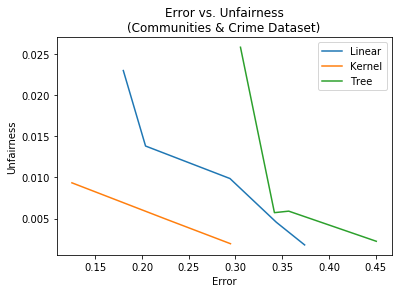

In [5]:
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05], save_results=False):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': 200},
                      'Tree': {'predictor': tree_predictor, 'iters': 200},
                      'Kernel': {'predictor': kernel_predictor, 'iters': 200}}

    results_dict = {}

    for pred in predictor_dict:
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = Model(C=100, printflag=False, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.set_options(max_iters=max_iters)
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Communities & Crime Dataset)')
    plt.show()
    
    
multiple_classifiers_pareto(data_set)

### FP vs. FN rate tradeoff
In our final example, we explore the following question: as a rich subgroup fair classifier becomes increasingly fair with respect to a fixed rate such as false positive rate, how does fairness with respect to other statistical rates change? In particular we would conjecture that all else being equal the false negative rate disparity would increase, since it is not encoded as an explicit fairness constraint, and could potentially be at odds with minimizing error. The below example shows this intuition to be generally correct, at least on the `Adult` dataset where we are mindful that 200 iterations may not be enough for convergence. 

([0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.010750000000000001, 0.01435, 0.023000000000000003], [0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.03560000000000001, 0.030149999999999996, 0.011600000000000003])


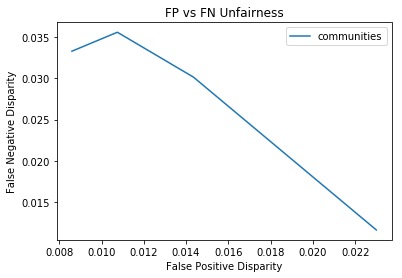

In [6]:

def fp_vs_fn(dataset, gamma_list):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        C = 10
        print_flag = False 
        max_iterations = 200
        fair_def = 'FP'
        fair_model = Model(C=C, printflag=print_flag, gamma=g, fairness_def=fair_def,
             max_iters=max_iterations)
        fair_model.set_options(gamma=g)
        fair_model.fit(dataset)
        predictions = (fair_model.predict(dataset)).labels
        predictions_inv = tuple([abs(1 - p) for p in predictions])
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions_inv)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    print((fp_violations, fn_violations))

    plt.plot(fp_violations, fn_violations, label='communities')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.show()
    
gamma_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.02, 0.03]
fp_vs_fn(data_set, gamma_list)